In [13]:
# Celda 1: Imports, configuración de la semilla y creación de la carpeta de archivos ───────────────────────────────────────

import numpy as np                      # Celdas: 2,3,4,5,6,7,8 (NP arrays, random choice with rng)
import matplotlib.pyplot as plt         # Celdas: 2,6,7,8 (Visualización, gráficos, animación)
import time                             # Celda: 5 (Medición de tiempos)
from tqdm import tqdm                   # Celda: 5 (Barra de progreso, opcional)
import argparse                         # Celdas: 1 (parseo de argumentos)
import sys                              # Para obtener argv en parse_known_args
from numba import njit, set_num_threads, get_num_threads, prange
import os                               # Para obtener el número de hilos disponibles
import h5py  # Para guardar resultados en formato HDF5
import subprocess, threading, re, math # Última celda para la generación del video

# ─── Configuración de semilla para reproducibilidad ──────────────────────────
seed = None                             # None = usar entropía del sistema
rng  = np.random.default_rng(seed)      # PCG64 RNG: seguro y adecuado para simulaciones

def establecer_numero_hilos(threads_percentage):
    #Establecemos el número de hilos a usar asegurándonos de que no exceda el número de hilos disponibles ni sea menor a 1
    n_threads_available = os.cpu_count()
    if n_threads_available is None:
        n_threads_available = 1  # Si no se puede determinar, usar al menos 1 hilo
    threads_percentage = max(1, min(100, threads_percentage))
    set_num_threads(int(n_threads_available*(threads_percentage / 100.0)))
    n_threads = get_num_threads()
    print(f"Usando {n_threads} hilos de {n_threads_available} disponibles ({threads_percentage}%).")


In [ ]:
# ─── Celda 2: Inicialización de la red y visualización ───────────────────────

# Generar configuración inicial aleatoria de espines ±1
def random_config_boundary(L, density):   
    config = np.ones((L, L), dtype=int)
    config[0, :] = -1  # Fila superior
    config[L-1, :] = 1  # Fila inferior                             # Creamos una matriz LxL de espines con valor +1, y
    for k in range(int(L * (L - 2) * (1 - density))):                     # aquí cambiamos N^2*(1 - densidad) espines a -1
        i, j = np.random.randint(1, L-1), np.random.randint(0, L)     # ya que la densidad es la proporción de espines +1
        config[i, j] = -1
    return config

def random_config_non_boundary(L, density):   
    config = np.ones((L, L), dtype=int)                            # Creamos una matriz LxL de espines con valor +1, y
    for k in range(int(L * L * (1 - density))):                     # aquí cambiamos N^2*(1 - densidad) espines a -1
        i, j = np.random.randint(0, L), np.random.randint(0, L)     # ya que la densidad es la proporción de espines +1
        config[i, j] = -1
    return config

# Forzar que la fila de arriba sea negativa y la de abajo positiva

# Ahora creamos una función para guardar la configuración inicial en un archivo .png, y que devuelva la configuración
def init_config(destino, L, density, Boundary_conditions):
    """
    Guarda la configuración inicial en un archivo .png.
    """
    if Boundary_conditions:
        config = random_config_boundary(L, density)  # Generar configuración aleatoria y fijar condiciones de frontera 
    elif not Boundary_conditions:
        config = random_config_non_boundary(L, density)
    plt.figure(figsize=(5, 5))
    plt.imshow(config, cmap='gray', interpolation='nearest')
    plt.title('Configuración inicial aleatoria')
    plt.axis('off')
    plt.savefig(destino, dpi=300, bbox_inches='tight')
    plt.close()
    return config

In [15]:
# ─── Celda 3: Definición de observables termodinámicos ─────────────────────

def energy(config, J):
    """
    Calcula la energía total del modelo de Ising 2D con contorno periódico.
    """
    # Enlaces derecha e inferior para contar cada par una sola vez
    right = np.roll(config, -1, axis=1)
    down  = np.roll(config, -1, axis=0)
    return -J * np.sum(config * (right + down))


def magnetization(config):
    """
    Calcula la magnetización total del sistema.
    """
    return np.sum(config)


In [16]:
# ─── Celda 4: Funciones del propio algoritmo de ising-kawasaki ──────────────

def calculate_acceptance(frames: np.ndarray) -> np.ndarray:
    
    nframes, H, W = frames.shape
    # `True` donde el espín cambió respecto al sweep anterior
    changes = frames[1:] != frames[:-1]               # shape (nframes-1, H, W)
    diff_counts = changes.reshape(nframes-1, -1).sum(axis=1)
    # Cada swap válido intercambia dos posiciones
    accepted_swaps = diff_counts / 2
    # Nº de intentos de swap por sweep ≈ H*W
    attempts = H * W
    acceptance = accepted_swaps / attempts
    return acceptance


@njit
def delta_E_kawasaki(config, i, j, k, l, J, L):
    """
    Calcula el cambio de energía ΔE para un intercambio de espines en la dinámica de Kawasaki.
    """
    delta_E = 0.0
    E_1 = 0.0
    E_2 = 0.0
    neighbors_ij = 0.0
    neighbors_kl = 0.0
    neighbors_ij = config[i,(j-1)%L] + config[(i-1)%L,j] + config[(i+1)%L,j] + config[i,(j+1)%L] - config[k, l]
    neighbors_kl = config[k,(l-1)%L] + config[(k-1)%L,l] + config[(k+1)%L,l] + config[k,(l+1)%L] - config[i, j]
    #Calculamos la energía de la configuración inicial
    E_1 = config[i,j]*neighbors_ij + config[k,l]*neighbors_kl
    #Calculamos la energía de la configuración final
    E_2 = config[k,l]*neighbors_ij + config[i,j]*neighbors_kl
    #Calculamos el cambio de energía
    delta_E = -J*(E_2 - E_1)
    return delta_E


#Paso de la simulación

@njit
def sweep_kawasaki_boundary(config, L, J, Beta):
    for k in range(((L-2)*L)):
        #Seleccionamos un espín aleatorio (i, j) de la red excluyendo las filas superior e inferior
        i, j = np.random.randint(1, L-1), np.random.randint(0, L)
        # Escribimos el espin seleccionado en un archivo para depuración
        # Definimos los offsets para los vecinos (arriba, abajo, izquierda, derecha)
        offsets = np.array([(1, 0), (0, 1), (0, -1),  (-1, 0)], dtype=np.int64)
        # Ahora seleccionamos un offset aleatorio que decidirá si escogemos un vecino arriba, abajo, izquierda o derecha
        #Hay que mantener la condición de los espines superior e inferior.
        # Entonces lo que hacemos es limitar los offsets a 3 si estamos en la fila superior o inferior, y a 4 si estamos en el resto de la red.
        # Y luego forzamos que si está en la fila
        if i == 1:
            di, dj = offsets[np.random.randint(0, 3)]
        elif i == L-2:
            di, dj = offsets[np.random.randint(1, 4)]
        else:
            di, dj = offsets[np.random.randint(0, 4)]
        # Ahora podemos calcular la posición exacta del espín vecino
        ni, nj = (i + di) % L, (j + dj) % L
        # Escribimos el espín vecino en el archivo para depuración
        # Ahora que tenemos la posición del espín vecino, comprobamos que no sea el mismo espín (i, j) que el vecino (ni, nj)
        if config[i, j] != config[ni, nj]:
            delta_E = delta_E_kawasaki(config, i, j, ni, nj, J, L)
            # Ahora que tenemos el ΔE, podemos decidir si aceptamos o no el movimiento
            # La condición básicamente es que para ΔE <= 0, aceptamos el movimiento, ya que de ser así la probabilidad de aceptación es 1.
            # Si ΔE > 0, aceptamos el movimiento con probabilidad p = exp(-ΔE/T), y lo más eficiente es generar un número aleatorio entre 0 y 1 y comparar con p,
            # ya que si el número aleatorio es menor o igual que p, aceptamos el movimiento.
            if delta_E <= 0 or np.random.rand() < np.exp(-delta_E * Beta):
                # Intercambiar espines
                config[i, j], config[ni, nj] = config[ni, nj], config[i, j]

@njit
def sweep_kawasaki_non_boundary(config, L, J, Beta):            
    for k in range(L*L):
        #Seleccionamos un espín aleatorio (i, j) de la red excluyendo las filas superior e inferior
        i, j = np.random.randint(0, L), np.random.randint(0, L)
        # Escribimos el espin seleccionado en un archivo para depuración
        # Definimos los offsets para los vecinos (arriba, abajo, izquierda, derecha)
        offsets = np.array([(1, 0), (0, 1), (0, -1),  (-1, 0)], dtype=np.int64)
        # Ahora seleccionamos un offset aleatorio que decidirá si escogemos un vecino arriba, abajo, izquierda o derecha
        #Hay que mantener la condición de los espines superior e inferior.
        # Entonces lo que hacemos es limitar los offsets a 3 si estamos en la fila superior o inferior, y a 4 si estamos en el resto de la red.
        # Y luego forzamos que si está en la fila
        di, dj = offsets[np.random.randint(0, 4)]
        # Ahora podemos calcular la posición exacta del espín vecino
        ni, nj = (i + di) % L, (j + dj) % L
        # Escribimos el espín vecino en el archivo para depuración
        # Ahora que tenemos la posición del espín vecino, comprobamos que no sea el mismo espín (i, j) que el vecino (ni, nj)
        if config[i, j] != config[ni, nj]:
            delta_E = delta_E_kawasaki(config, i, j, ni, nj, J, L)
            # Ahora que tenemos el ΔE, podemos decidir si aceptamos o no el movimiento
            # La condición básicamente es que para ΔE <= 0, aceptamos el movimiento, ya que de ser así la probabilidad de aceptación es 1.
            # Si ΔE > 0, aceptamos el movimiento con probabilidad p = exp(-ΔE/T), y lo más eficiente es generar un número aleatorio entre 0 y 1 y comparar con p,
            # ya que si el número aleatorio es menor o igual que p, aceptamos el movimiento.
            if delta_E <= 0 or np.random.rand() < np.exp(-delta_E * Beta):
                # Intercambiar espines
                config[i, j], config[ni, nj] = config[ni, nj], config[i, j]
    


In [17]:
# ─── Celda 5: Función del bucle Monte Carlo y recolección de datos con HDF5 ────────────
# Funciones para plotear los datos importantes


"""
def compute_slope(x: np.ndarray, y: np.ndarray) -> float:
    # polyfit devuelve [m, b]
    m, _ = np.polyfit(x, y, 1)
    return m

def check_stability(acceptance: np.ndarray, current_step: int, window: int, slope_threshold: float, N: int) -> bool:
    # Índices de los últimos `window` sweeps
    x = np.arange(current_step + 1 - window, current_step + 1)
    y = acceptance[-window:]
    slope = compute_slope(x, y)
    # Debug opcional:
    print(f"[Step {current_step+1}] Pendiente del ajuste: {slope:.2e}")
    return abs(slope) < slope_threshold
"""

def plot_observables(energies, magnetizations, n_sweeps, destino):
    # ─── Acceptance rate ────────────────────────────────

    # 1) Cargar todos los frames desde el HDF5
    with h5py.File(os.path.join(destino, 'configs.h5'), 'r') as f:
        frames = f['configs'][:]    # np.ndarray (nframes, H, W)

    # 2) Calcular la aceptación
    acceptance = calculate_acceptance(frames)

    # 3) Representar la evolución de la tasa de aceptación
    sweeps = np.arange(1, len(acceptance) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(sweeps, acceptance, linestyle='-')
    plt.xlabel('Sweep')
    plt.ylabel('Acceptance rate')
    plt.title('Evolución de la tasa de aceptación (Kawasaki)')
    plt.grid(True)
    plt.tight_layout()

    # 4) Guardar la figura
    plt.savefig(os.path.join(destino, 'acceptance_rate.png'), dpi=300, bbox_inches='tight')

    # ─── Energía ────────────────────────────────

    n_sweeps_array = np.arange(n_sweeps + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(n_sweeps_array, energies, linestyle='-')
    plt.xlabel('Sweep')
    plt.ylabel('Energía')
    plt.title('Energía del sistema (Kawasaki)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(destino, 'energy.png'), dpi=300, bbox_inches='tight')
    
    # ─── Magnetización ────────────────────────────────

    plt.figure(figsize=(6, 4))
    plt.plot(n_sweeps_array, magnetizations, linestyle='-')
    plt.xlabel('Sweep')
    plt.ylabel('Magnetización')
    plt.title('Magnetización del sistema (Kawasaki)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(destino, 'magnetization.png'), dpi=300, bbox_inches='tight')

def run_monte_carlo(L, J, T, n_sweeps, thin, destino, Boundary_conditions, density, N, window, slope_threshold):

    # ─── Inicialización de la simulación ────────────────────────────────
    
    config = init_config(os.path.join(destino, "init_config.png"), L, density, Boundary_conditions)  # Guardar configuración inicial
    
    # Inicializar arrays para almacenar energía y magnetización
    energies = np.zeros(n_sweeps + 1)
    magnetizations = np.zeros(n_sweeps + 1)
    
    # Calcular Beta
    Beta = 1.0 / T

    # Parámetros de guardado
    

    with h5py.File(os.path.join(destino, 'configs.h5'), 'w') as f:
        # Dataset para las configuraciones: snapshots × L × L, dtype int8
        dataset = f.create_dataset(
            'configs',                      # 1. Nombre del dataset dentro del archivo HDF5
            shape=(n_sweeps + 1, L, L),          # 2. Dimensiones: n_saved muestras de matrices L×L     
            dtype='i1',                     # 3. Tipo de dato: int8 (espines ±1)
            compression='gzip',             # 4. Compresión: algoritmo gzip
            compression_opts=4,             # 5. Nivel de compresión (1=rápido/menos compacto … 9=lento/máximo)
            chunks=(1, L, L),               # 6. Fragmentación (“chunking”): cada bloque es una matriz L×L
        )
        # Metadatos
        f.attrs['J'] = J
        f.attrs['T'] = T
        f.attrs['L'] = L
        f.attrs['n_sweeps'] = n_sweeps
        f.attrs['thin'] = thin

        # Medir estado inicial
        energies[0] = energy(config, J)
        magnetizations[0] = magnetization(config)
        # Guardar configuración inicial ds[0]
        dataset[0, :, :] = config

        # Barrido Monte Carlo
        start_time = time.time()
        for sweep in tqdm(range(1, n_sweeps + 1), desc='MC Sweeps'):  # Esto es una simple barra de progreso, nada más
            # Ahora podemos barrer la red para elegir el par de espines a intercambiar.
            if Boundary_conditions:
                sweep_kawasaki_boundary(config, L, J, Beta)
            else:
                sweep_kawasaki_non_boundary(config, L, J, Beta)
            # Registrar observables
            energies[sweep] = energy(config, J)
            magnetizations[sweep] = magnetization(config)

            # Almacenar las configuraciones 
            
            dataset[sweep, :, :] = config

            
            """
            if (sweep + 1) % N == 0:
                with h5py.File(os.path.join(destino, 'configs.h5'), 'r') as f:
                    frames = f['configs'][:]    # np.ndarray (nframes, H, W)
                # Comprobar estabilidad de la tasa de aceptación
                acceptance = calculate_acceptance(frames)
                if check_stability(acceptance, sweep, window, slope_threshold, N):
                    print(f"Simulación estable en el sweep {sweep + 1}, deteniendo la simulación.")
                    break
            """    

        end_time = time.time()

        print(f"Simulación completada en {end_time - start_time:.2f} s")
    
    # Graficar y guardar observables
    plot_observables(energies, magnetizations, n_sweeps, destino)





In [22]:
# Celda 6: pipeline GPU-BOUND con NVENC a partir de HDF5

def generate_video_from_hdf5(HDF5_FILE, DATASET, FILE_OUT, GPU_ID, INTERVAL, TARGET_W, TARGET_H, MIN_SIDE, destino, thin):

    # 1) Cargar datos --------------------------------------------------------------
    with h5py.File(os.path.join(destino, HDF5_FILE), 'r') as f:
        frames = f[DATASET][::thin]
    nframes, h0, w0 = frames.shape
    fps = 1000.0 / INTERVAL
    print(f"→ {nframes} frames ({w0}×{h0}px) @ {fps:.1f} fps")

    # 2) Calcular resolución de salida --------------------------------------------
    w_out, h_out = w0, h0
    if TARGET_W and not TARGET_H:
        scale = TARGET_W / w0
        w_out = TARGET_W
        h_out = int(round(h0 * scale))
    elif TARGET_H and not TARGET_W:
        scale = TARGET_H / h0
        h_out = TARGET_H
        w_out = int(round(w0 * scale))
    elif TARGET_W and TARGET_H:
        w_out, h_out = TARGET_W, TARGET_H

    # Asegurar mínimo NVENC
    if min(w_out, h_out) < MIN_SIDE:
        factor = math.ceil(MIN_SIDE / min(w_out, h_out))
        w_out *= factor
        h_out *= factor
        print(f"⚠️ Redimensionado extra para mínimo NVENC ({MIN_SIDE}px)")

    # Redondear a par
    w_out = (w_out // 2) * 2
    h_out = (h_out // 2) * 2
    if (w_out, h_out) != (w0, h0):
        print(f"🔧 Escalando: {w0}×{h0} → {w_out}×{h_out}")
    vf_filter = ["-vf", f"scale={w_out}:{h_out}:flags=neighbor"] if (w_out, h_out) != (w0, h0) else []

    # 3) Detectar NVENC ------------------------------------------------------------
    encoders = subprocess.run(
        ["ffmpeg", "-hide_banner", "-encoders"],
        capture_output=True, text=True
    ).stdout
    if "h264_nvenc" in encoders:
        print("✅ h264_nvenc detectado → GPU")
        video_opts = [
            "-c:v", "h264_nvenc", "-gpu", str(GPU_ID),
            "-preset", "p1", "-profile:v", "high444p", "-pix_fmt", "yuv444p"
        ]
    else:
        print("⚠️ NVENC no disponible → libx264 (CPU)")
        video_opts = ["-c:v", "libx264", "-preset", "veryslow", "-crf", "0", "-pix_fmt", "yuv420p"]

    # 4) Comando FFmpeg ------------------------------------------------------------
    cmd = (
        ["ffmpeg", "-y",
        "-f", "rawvideo", "-pix_fmt", "rgb24",
        "-s", f"{w0}x{h0}", "-r", str(fps), "-i", "-",
        "-progress", "pipe:1", "-loglevel", "error"]
        + vf_filter + video_opts + [f"{os.path.join(destino, FILE_OUT)}.mp4"]
    )
    print("FFmpeg:", " ".join(cmd))

    # 5) Lanzar FFmpeg -------------------------------------------------------------
    proc = subprocess.Popen(
        cmd,
        stdin = subprocess.PIPE,
        stdout = subprocess.PIPE,
        stderr = subprocess.PIPE,
        bufsize = 0
    )

    # 6) Barra de codificación -----------------------------------------------------
    pbar_enc = tqdm(total=nframes, desc="🛠️ Codificando", unit="frame")
    def _watch():
        re_time = re.compile(rb"out_time_ms=(\d+)")
        re_fr   = re.compile(rb"frame=(\d+)")
        while True:
            line = proc.stdout.readline()
            if not line:
                break
            m = re_fr.search(line) or re_time.search(line)
            if m:
                val = int(m.group(1))
                done = val if b"frame" in line else min(nframes, int(round(val * fps / 1000)))
                pbar_enc.n = done
                pbar_enc.refresh()

    threading.Thread(target=_watch, daemon=True).start()

    # 7) Enviar frames -------------------------------------------------------------
    with tqdm(total=nframes, desc="📤 Enviando frames", unit="frame") as pbar_in:
        for frame in frames:
            # Convertir de Ising (-1,+1) a [0,255] y a RGB
            rgb = np.repeat(((frame + 1) * 127.5).astype(np.uint8)[..., None], 3, axis=2)
            proc.stdin.write(rgb.tobytes())
            pbar_in.update(1)

    proc.stdin.close()
    proc.wait()
    pbar_enc.n = nframes
    pbar_enc.refresh()
    pbar_enc.close()

    print(f"🎉 Vídeo generado: {os.path.join(destino, FILE_OUT)}.mp4 ({w_out}×{h_out})")


In [23]:
# ─── Celda 7: Definición de función de simulación completa ─────────────────────────────────────────

def run_whole_simulation(L, J, T, n_sweeps, threads_percentage, thin, Boundary_conditions, density,N, window, slope_threshold, HDF5_FILE, DATASET, FILE_OUT, GPU_ID, INTERVAL, TARGET_W, TARGET_H, MIN_SIDE):

    # ─── Establecer el número de hilos a usar ──────────────────────────────────────────────────────────────────────────

    establecer_numero_hilos(threads_percentage)  

    # ─── Definición nombre carpeta ─────────────────────────────────────────────────────────────────────────────────────

    carpeta = "results"                                                                                     # La idea en esta parte es simple, queremos crear
    if not os.path.exists(carpeta):                                                                         # una carpeta de resultados siempre que hagamos una
        os.makedirs(carpeta)                                                                                # simulación, la hayamos hecho antes o no, y que sea única.
    destino_base = os.path.join(carpeta, f"L{L}_J{J}_T{T}_sweeps{n_sweeps}_threads{threads_percentage}")    # Con este fin, hemos hecho un pequeño bucle que comprueba
    destino = destino_base                                                                                  # si la carpeta ya existe, y si es así, le añade un número 
    counter = 1                                                                                             # al final de la carpeta, para que sea única.
    while os.path.exists(destino):
        destino = f"{destino_base}_({counter})" 
        counter += 1
    os.makedirs(destino)  # Crear una carpeta de destino única

    # Ahora ejecutamos el programa completo

    run_monte_carlo(L, J, T, n_sweeps, thin, destino, Boundary_conditions, density, N, window, slope_threshold)

    generate_video_from_hdf5(HDF5_FILE, DATASET, FILE_OUT, GPU_ID, INTERVAL, TARGET_W, TARGET_H, MIN_SIDE, destino, thin)




In [26]:
# ─── Celda 8: Parámetros predeterminados ───────────────────────────────────────────────────────────────────────────

# ─── Parámetros base del modelo ────────────────────────────────────────────────────────────────────────────────────
L                   = 8                     # (int) Tamaño de la red (LxL)
J                   = 1.0                   # (float) Constante de interacción (J > 0 para ferromagnetismo)
T                   = 1.0                   # (float) Temperatura del modelo de Ising 2D
n_sweeps            = 100000                # (int) Número de sweeps (barridos) a realizar
density             = 0.5                   # (float) Densidad de espines +1
threads_percentage  = 100                   # (int) Porcentaje de hilos a usar (100% = todos los disponibles)
thin                = 500                   # (int) Frecuencia de guardado de configuraciones (1 = cada sweep, 2 = cada 2 sweeps, etc.)     
Boundary_conditions = True                  # (bool) Condiciones de frontera (True = eje "y" limitado, False = periódicas)
N                   = 1000                  # (int) Número de sweeps para comprobar estabilidad de la tasa de aceptación
window              = 1000                  # (int) Ventana de sweeps para comprobar estabilidad de la tasa de aceptación
slope_threshold     = 1e-5                  # (float) Umbral de pendiente para considerar estable la tasa de aceptación

# ─── Parámetros de usuario para la generación del vídeo ────────────────────────────────────────────────────────────

HDF5_FILE = "configs.h5"                    # Nombre del archivo HDF5 con las configuraciones
DATASET   = "configs"                       # Nombre del dataset dentro del archivo HDF5
FILE_OUT  = "simulacion"                    # Nombre del archivo de salida (sin extensión ni ruta)
GPU_ID    = 0                               # 0 = tu NVIDIA 4050
INTERVAL  = 50                              # ms entre frames → fps = 1000/INTERVAL
TARGET_W  = 1440                            # ancho deseado; None para mantener original
TARGET_H  = None                            # alto deseado; None para mantener original
MIN_SIDE  = 160                             # mínimo seguro para NVENC (≥ 145 y par)

# Hemos reducido todo el programa a una sola función que recibe todos los parámetros necesarios.
# Ahora podemos ejecutar múltiples simulaciones con diferentes parámetros y 
# vamos a preparar una secuencia de opciones para el usuario, 
# para que vaya eligiendo qué tipo de simulación quiere hacer.

Usando 16 hilos de 16 disponibles (100%).


MC Sweeps: 100%|██████████| 100000/100000 [00:15<00:00, 6591.14it/s]


Simulación completada en 15.18 s
→ 201 frames (8×8px) @ 20.0 fps
🔧 Escalando: 8×8 → 1440×1440
✅ h264_nvenc detectado → GPU
FFmpeg: ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 8x8 -r 20.0 -i - -progress pipe:1 -loglevel error -vf scale=1440:1440:flags=neighbor -c:v h264_nvenc -gpu 0 -preset p1 -profile:v high444p -pix_fmt yuv444p results\L8_J1.0_T1.0_sweeps100000_threads100\simulacion.mp4


🛠️ Codificando: 100%|██████████| 201/201 [00:00<00:00, 293.64frame/s]


🎉 Vídeo generado: results\L8_J1.0_T1.0_sweeps100000_threads100\simulacion.mp4 (1440×1440)


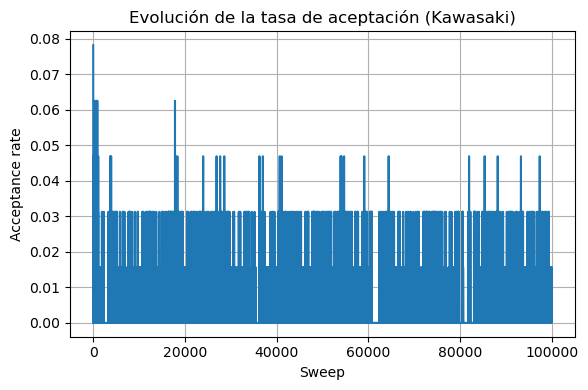

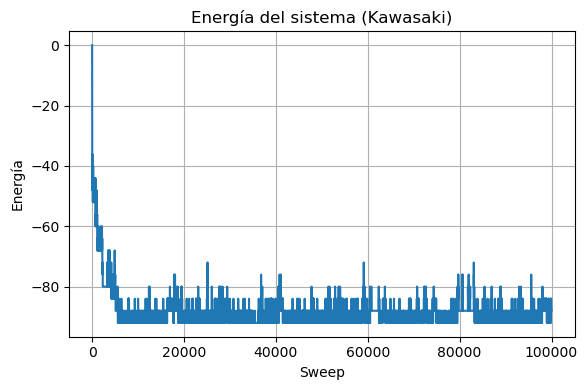

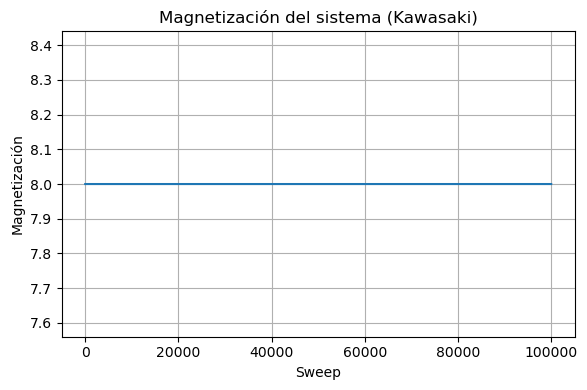

In [27]:
# ─── Celda Extra: Ejecución única de la simulación ─────────────────────────────────────────────────────────────────────

run_whole_simulation(L, J, T, n_sweeps, threads_percentage, thin, Boundary_conditions, density, N, window, slope_threshold, HDF5_FILE, DATASET, FILE_OUT, GPU_ID, INTERVAL, TARGET_W, TARGET_H, MIN_SIDE)

In [ ]:
# ─── Celda 9: Interfaz del usuario, configuración de los parámetros del modelo ─────────────────────────────────────────────────────────────────────

# Primero describimos qué hace el programa y qué opciones tiene el usuario
print("Simulador de Ising 2D con dinámica de Kawasaki\n")
print("Quiere hacer una simulación única o múltiples simulaciones?:\n")
print("1. Simulación única\n")
print("2. Múltiples simulaciones\n")

